<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/Merge_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

KeyboardInterrupt: ignored

In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 240 (delta 130), reused 114 (delta 48), pack-reused 0
Receiving objects: 100% (240/240), 4.37 MiB | 3.91 MiB/s, done.
Resolving deltas: 100% (130/130), done.
     - 57.1MB 2.8MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30856 sha256=b1bfc6f8f993aa397cee28497e864005aa8b50fafa4c591f8134b693a511d76d
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqj63c8o/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2

from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st

import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [5]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 75, 224, 224, 3) (12, 15, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

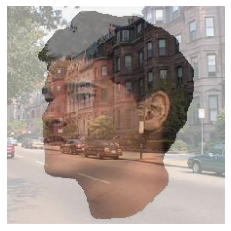

In [6]:
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

Category of interest:  Female
(150, 224, 224, 3) (30, 224, 224, 3)


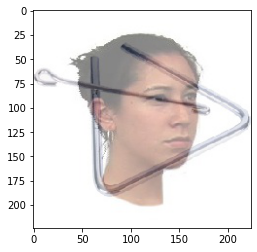

In [7]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 1
print('Category of interest: ', categories[interest])
train_it = np.concatenate((data_train[interest],data_train[interest + 6]))
test_it = np.concatenate((data_test[interest],data_test[interest + 6]))
print(train_it.shape,test_it.shape)

plt.imshow(train_it[10])

# Model

In [8]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')



58892288/58889256 [==============================] - 1s 0us/step
Train Time: 9.725394010543823
Test Time: 1.3260345458984375


In [9]:
epochs = 30

#train_data = np.load('features_train.npy')
ntrain = 75
train_data = features_train
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


#test_data = np.load('features_test.npy')
ntest = 15
test_data = features_test
test_labels = to_categorical([0] * ntest + [1]*ntest)



In [11]:
losses = 'binary_crossentropy'

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='linear',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          verbose = 1, callbacks = [es])

out = top_model.evaluate(test_data, test_labels)
print(out)
#print('rounded test labels',pred)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3/3 [==============================] - 0s 22ms/step - loss: 2.7979 - accuracy: 0.5133
Epoch 2/30
3/3 [==============================] - 0s 20ms/step - loss: 2.1477 - accuracy: 0.6800
Epoch 3/30
3/3 [==============================] - 0s 19ms/step - loss: 2.5608 - accuracy: 0.6800
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 1.0369 -

Normalized confusion matrix


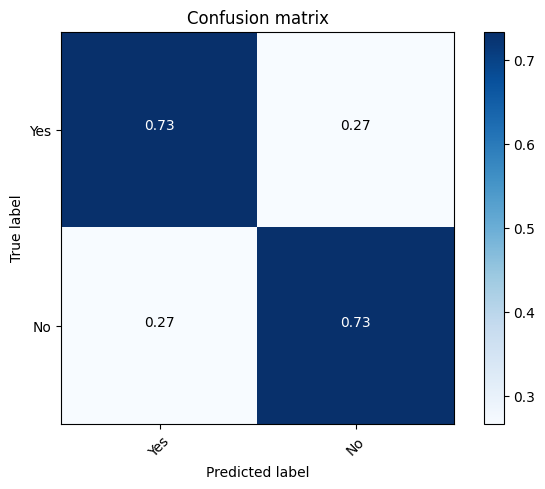

In [12]:
classes = ['Yes','No']
#classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')
pred = top_model.predict(test_data)
from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

# Tuning Value Calculation

In [13]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 1
for interest in range(6): 

  print('Category of interest: ', categories[interest])
  train_it = np.concatenate((data_train[interest],data_train[interest + 6]))
  test_it = np.concatenate((data_test[interest],data_test[interest + 6]))
  print(train_it.shape,test_it.shape)

  
  if calc_tun_activ:
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(interest), 'wb') as fp:
        pickle.dump(tun_activ, fp)



Category of interest:  Male
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 29.16580820083618s
Category of interest:  Female
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 28.89431357383728s
Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 28.986409664154053s
Category of interest:  Natural
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 29.310855388641357s
Category of interest:  Powered
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 29.008130311965942s
Category of interest:  Nonpowered
(150, 224, 224, 3) (30, 224, 224, 3)
Elapsed: 28.99714756011963s


In [14]:
tun_activ = []
for interest in range(6): 
  with open ('/content/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)

900

### Calculation of tuning values for each map

In [15]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 150 + [1]*150 + [2] * 150 + [3] * 150 + [4] * 150 + [5] * 150)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


(0.0, 10.0)

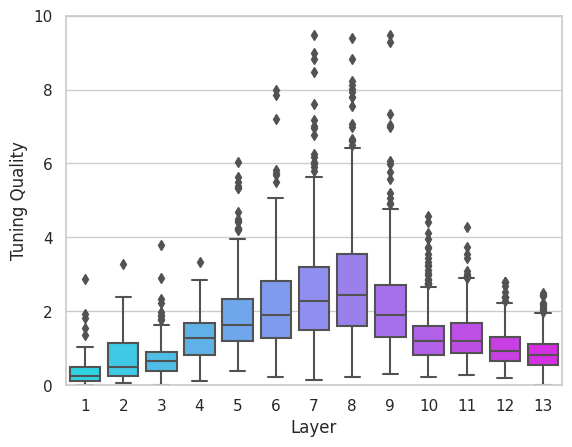

In [16]:
tun_quality = tc.calc_tun_quality(fc)
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,10])

# Gradient Value Calculations

In [17]:
with open ('/content/drive/My Drive/obj/gradient_values_cat', 'rb') as fp:
    cat_grads = pickle.load(fp)

# Attention

In [19]:
from vgg16obj.tools import model_calcs as mc
layeridx = 0
mc.avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 categories,fc,model,top_model,layeridx)

Category of interest:  Male
(150, 224, 224, 3) (30, 224, 224, 3)
Category of interest:  Female
(150, 224, 224, 3) (30, 224, 224, 3)
Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
Category of interest:  Natural
(150, 224, 224, 3) (30, 224, 224, 3)
Category of interest:  Powered
(150, 224, 224, 3) (30, 224, 224, 3)
Category of interest:  Nonpowered
(150, 224, 224, 3) (30, 224, 224, 3)


NameError: ignored

In [ ]:
plt.plot(t_acc)
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure()
ax = sns.pointplot(data = d1 , color = 'mediumseagreen', errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)
